# Klasteryzacja posłów

Czy możemy pogrupować posłów wg rozkładów po tematach?

Jak wyniki będą się różniły od przypisania do partii?

In [1]:
import re
import pandas as pd
import numpy as np
import funcs 
import importlib
import unicodecsv as csv
import pickle
import random
import gensim
from gensim import corpora, models
from timeit import default_timer as timer
from datetime import datetime, timedelta
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import spacy
from collections import Counter
import pyLDAvis
import pyLDAvis.gensim
from sklearn.model_selection import train_test_split

importlib.reload(funcs)

<module 'funcs' from 'D:\\_projekty\\praca\\funcs.py'>

In [2]:
dane = pd.read_csv('00_dane/dane_TM.csv',  sep='|', encoding='UTF-8')
dane['speech_rawest'] = dane['speech_rawest'].apply(lambda x: re.sub(r'[\W\d]',' ', x.lower()))
nlp = spacy.load('pl_model')
stop = set(nlp.Defaults.stop_words)
stop.add('zł')
stop.add('pkt')
stop.add('art')
stop.add('ustawy')
stop.add('r')
dane['speech_rawest'] = dane['speech_rawest'].apply(lambda x: [word for word in x.split() if word not in stop])
dane = dane[dane['full_name'].apply(lambda x:isinstance(x, str))]
dane = dane.reset_index()
dane = dane.drop('index', axis=1)
dane.to_csv('00_dane/dane_cleanest.csv', sep='|', encoding='UTF-8', index = False)

### Przygotowanie danych:

1. Wybór liczniejszych partii
2. Przypisanie wektorów tematycznych posłom

#### 1. Wybór posłów

In [38]:
dane.head(1)

,nr,date_,speech_rawer,full_name,party_final,speech_rawest,topic_LDA_BOW,topic_LDA_TF,opis_LDA_BOW,opis_LDA_TF
0,0,01-02-1992,Chciałbym kilka zdań powiedzieć na temat skut...,Aleksander Bentkowski,Polskie Stronnictwo Ludowe,"[chcieć, zdanie, powiedzieć, temat, skutek, us...",16.0,13.0,wymiar sprawiedliwości,przepisy


In [194]:
PP = dane[(dane['party_final']=='Prawo i Sprawiedliwość') | (dane['party_final']=='Platforma Obywatelska')
         | (dane['party_final']=='Akcja Wyborcza Solidarność')
         | (dane['party_final']=='Sojusz Lewicy Demokratycznej') | (dane['party_final']=='Polskie Stronnictwo Ludowe')][['full_name', 'party_final']]
PP = PP.drop_duplicates()
PP = PP.reset_index()
PP = PP.drop('index', axis=1)

In [192]:
aa = dane[['full_name', 'party_final']]
aa = aa.drop_duplicates()
Counter(aa.party_final)

Counter({'Polskie Stronnictwo Ludowe': 198,
         'Sojusz Lewicy Demokratycznej': 311,
         'Klub Parlamentarny NSZZ Solidarność': 16,
         'Klub Parlamentarny Zjednoczenia Chrześcijańsko-Narodowego': 25,
         'Klub Parlamentarny Unii Wolności \r\n': 42,
         'Klub Polski Program Liberalny': 36,
         'Koło Poselskie Konserwatywno-Ludowe\r\n': 5,
         'Klub Parlamentarny Konwencja Polska': 17,
         'posłowie niezrzeszeni': 109,
         'Klub Parlamentarny Konfederacji Polski Niepodległej': 31,
         'Klub Parlamentarny Ruch dla Rzeczypospolitej': 11,
         'Koło Poselskie Socjaldemokracji Polskiej\r\n': 2,
         'Klub Parlamentarny Unii Wolności': 26,
         'Platforma Obywatelska': 276,
         'posłowie niezrzeszeni\r\n': 21,
         'Prawo i Sprawiedliwość': 317,
         'Klub Parlamentarny Unia Demokratyczna': 15,
         'Klub Parlamentarny Stronnictwa Konserwatywno-Ludowego\r\n': 7,
         'Koło Parlamentarne Konfederacji Polski Nie

In [191]:
aa

,full_name,party_final
0,Aleksander Bentkowski,Polskie Stronnictwo Ludowe
1,Aleksander Kwaśniewski,Sojusz Lewicy Demokratycznej
2,Alojzy Pietrzyk,Klub Parlamentarny NSZZ Solidarność
3,Alojzy Szablewski,Klub Parlamentarny Zjednoczenia Chrześcijańsko...
4,Andrzej Baraniecki,Sojusz Lewicy Demokratycznej
...,...,...
145050,Leszek Bubel,posłowie niezrzeszeni
146381,Ryszard Bonda,posłowie niezrzeszeni
149739,Jerzy Orłowski,Klub Polski Program Liberalny
152403,Stanisław Wąsik,Klub Parlamentarny NSZZ Solidarność


In [195]:
Counter(PP.party_final)

Counter({'Polskie Stronnictwo Ludowe': 198,
         'Sojusz Lewicy Demokratycznej': 311,
         'Platforma Obywatelska': 276,
         'Prawo i Sprawiedliwość': 317,
         'Akcja Wyborcza Solidarność': 124})

In [100]:
PP.head()

,full_name,party_final
0,Aleksander Bentkowski,Polskie Stronnictwo Ludowe
1,Aleksander Kwaśniewski,Sojusz Lewicy Demokratycznej
2,Andrzej Baraniecki,Sojusz Lewicy Demokratycznej
3,Danuta Waniek,Sojusz Lewicy Demokratycznej
4,Irena Nowacka,Sojusz Lewicy Demokratycznej


In [196]:
set(PP.party_final)

{'Akcja Wyborcza Solidarność',
 'Platforma Obywatelska',
 'Polskie Stronnictwo Ludowe',
 'Prawo i Sprawiedliwość',
 'Sojusz Lewicy Demokratycznej'}

#### 2. Przypisanie wektorów tematycznych

#### Załadowanie modelu

In [50]:
model = pickle.load(open('model_atm.p', 'rb'))

Dodanie kolumnz z zerami jako domyślnymi wartościami

In [197]:
PP = dane[(dane['party_final']=='Prawo i Sprawiedliwość') | (dane['party_final']=='Platforma Obywatelska')
         | (dane['party_final']=='Akcja Wyborcza Solidarność')
         | (dane['party_final']=='Sojusz Lewicy Demokratycznej') | (dane['party_final']=='Polskie Stronnictwo Ludowe')][['full_name', 'party_final']]
PP = PP.drop_duplicates()
PP = PP.reset_index()
PP = PP.drop('index', axis=1)
z = pd.DataFrame(np.zeros((PP.shape[0],30)))
PP = pd.concat([PP, z], axis=1 )

In [198]:
PP.head()

,full_name,party_final,0,1,2,3,4,5,6,7,...,20,21,22,23,24,25,26,27,28,29
0,Aleksander Bentkowski,Polskie Stronnictwo Ludowe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aleksander Kwaśniewski,Sojusz Lewicy Demokratycznej,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Andrzej Baraniecki,Sojusz Lewicy Demokratycznej,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Danuta Waniek,Sojusz Lewicy Demokratycznej,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Irena Nowacka,Sojusz Lewicy Demokratycznej,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
PP.shape[0]

1156

#### Wpisanie prawdopodobieństw w kolumny

In [199]:
for i in PP.index:
    pos = PP.iloc[i]['full_name']
    p_df = pd.DataFrame(model.get_author_topics(pos), columns=['nr_t', 'pr'])
    for topic, prob in zip(p_df['nr_t'], p_df['pr']):
        PP.at[i, topic] = prob

In [200]:
PP[PP['full_name']=='Elżbieta Witek']


,full_name,party_final,0,1,2,3,4,5,6,7,...,20,21,22,23,24,25,26,27,28,29
549,Elżbieta Witek,Prawo i Sprawiedliwość,0.0,0.010174,0.014873,0.024079,0.0,0.105116,0.01823,0.22354,...,0.042009,0.065132,0.0,0.0,0.031326,0.033539,0.012191,0.039969,0.036021,0.014318


In [51]:
model.get_author_topics('Elżbieta Witek')

[(1, 0.010173695171435126),
 (2, 0.014872677386877869),
 (3, 0.02407901524157414),
 (5, 0.10511610697817833),
 (6, 0.018229619890880247),
 (7, 0.2235401804266464),
 (8, 0.1712791074742982),
 (11, 0.02212356055109756),
 (12, 0.01838168075407171),
 (13, 0.02287676835633774),
 (14, 0.017514451907634475),
 (18, 0.015027905440992353),
 (19, 0.03473897075465472),
 (20, 0.04200934650766345),
 (21, 0.06513185956774548),
 (24, 0.031326426080217025),
 (25, 0.03353918415974472),
 (26, 0.0121908155606172),
 (27, 0.03996850684097312),
 (28, 0.036020736323498705),
 (29, 0.014318267145241299)]

### Podział na grupy

In [123]:
from sklearn.cluster import KMeans

In [150]:
PP.head()

,full_name,party_final,0,1,2,3,4,5,6,7,...,21,22,23,24,25,26,27,28,29,cluster
0,Aleksander Bentkowski,Polskie Stronnictwo Ludowe,0.016329,0.000000,0.000000,0.000000,0.000000,0.025951,0.017050,0.000000,...,0.050733,0.0,0.000000,0.000000,0.000000,0.0,0.144057,0.025955,0.000000,5
1,Aleksander Kwaśniewski,Sojusz Lewicy Demokratycznej,0.000000,0.014935,0.000000,0.000000,0.087183,0.000000,0.056844,0.014710,...,0.088450,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.045425,0.018430,1
2,Andrzej Baraniecki,Sojusz Lewicy Demokratycznej,0.017562,0.045108,0.000000,0.027715,0.027780,0.010665,0.025111,0.000000,...,0.129243,0.0,0.010669,0.044385,0.016485,0.0,0.028154,0.039115,0.024910,1
3,Danuta Waniek,Sojusz Lewicy Demokratycznej,0.000000,0.072008,0.000000,0.089956,0.050291,0.015797,0.064131,0.081133,...,0.058760,0.0,0.000000,0.011286,0.015680,0.0,0.058784,0.022937,0.015485,1
4,Irena Nowacka,Sojusz Lewicy Demokratycznej,0.011017,0.028715,0.013483,0.044902,0.031392,0.049587,0.022568,0.228824,...,0.037328,0.0,0.000000,0.000000,0.016015,0.0,0.027311,0.054144,0.000000,4


In [201]:
kmeans = KMeans(n_clusters=5).fit(PP.iloc[:, 2:])
centroids = kmeans.cluster_centers_
#dir(kmeans)

In [203]:
#PP = PP.drop('cluster', axis=1)
PP = pd.concat([PP, pd.Series(kmeans.labels_, name='cluster')], axis=1)

Rozkład grup

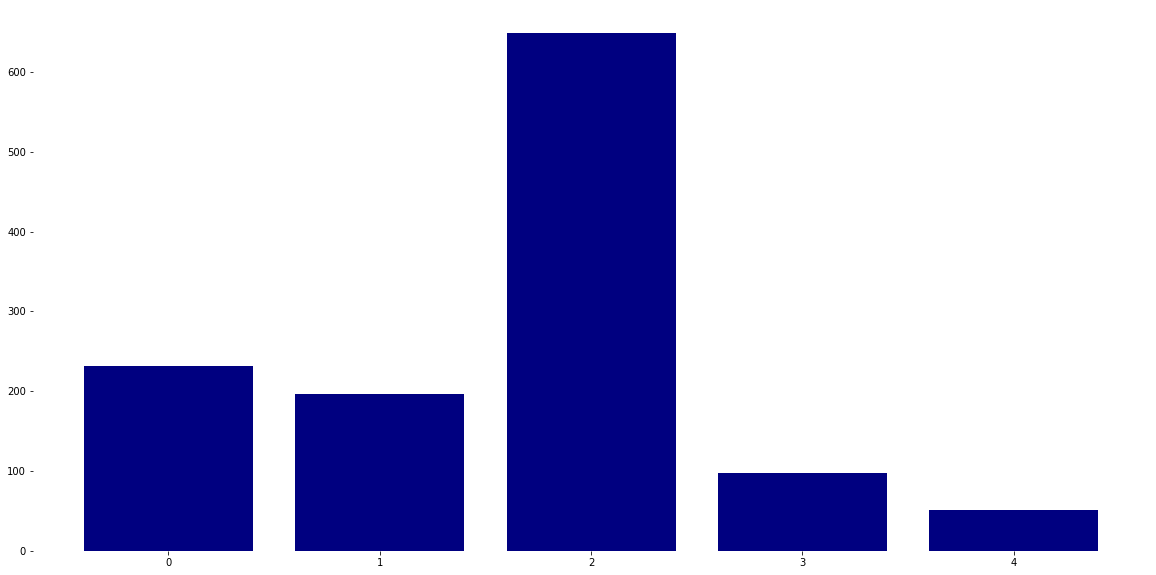

In [205]:
a = Counter(PP['cluster'])

fig = plt.figure(figsize=(20,10))
bars = plt.bar(list(a.keys()), list(a.values()), align='center', linewidth=0, color='navy')
plt.box(False)
#plt.xticks(rotation=70)

<Figure size 1440x720 with 0 Axes>

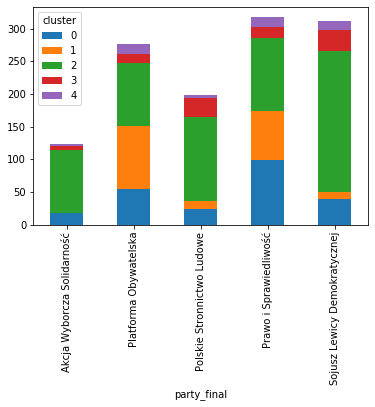

In [206]:
fig = plt.figure(figsize=(20,10))
ct = pd.crosstab(PP.party_final, PP.cluster)

ct.plot.bar(stacked=True)

In [207]:
ct

cluster,0,1,2,3,4
party_final,,,,,
Akcja Wyborcza Solidarność,17,0,97,6,4
Platforma Obywatelska,55,96,97,13,15
Polskie Stronnictwo Ludowe,23,13,128,30,4
Prawo i Sprawiedliwość,98,76,111,18,14
Sojusz Lewicy Demokratycznej,39,11,216,31,14


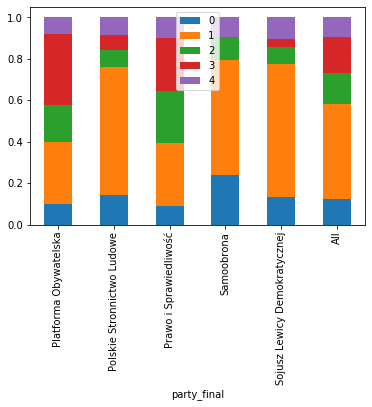

In [178]:
ct2 = pd.crosstab(PP.party_final, PP.cluster, margins = True, normalize= 'index')
p1 = ct2.plot.bar(stacked = True)
plt.legend(loc=9)

#### Czy inna liczba grup byłaby lepsza?

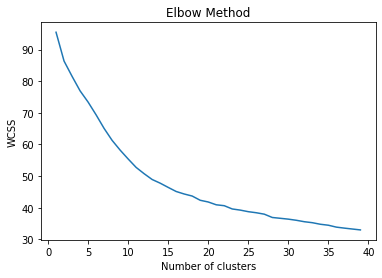

In [132]:
wcss = []
for i in range(1, 40):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(PP.iloc[:, 2:])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 40), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()